# Modelling hundreds of possible liquid-line-of-descent paths

- The previous notebook demonstrates how pyMELTScalc can be used to perform a small number of fractional crystallisation models simultaneously.
- In some cases, however, the user may wish to test a larger range of possible input parameters. This notebook demonstrates how that can be done.

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files (https://magmasource.caltech.edu/gitlist/MELTS_Matlab.git/) and store them locally on their computer. These files then need to be added to the Python path by using the $sys.path.append()$ command below.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/pyMELTScalc/blob/master/docs/Examples/CrystallisationTests/Fernandina_glass.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyMELTScalc as M

import sys
sys.path.append(r"MELTS")

In this notebook we'll use the same Isla Fernandina melt inclusion and submarine glass data as the previous notebook, but explore a wider range of starting conditions. For the first example we'll show how we can explore multiple pressures, melt H$_2$O and CO$_2$ contents, and fO$_2$ values.

In [2]:
df = pd.read_excel('Fernandina_glass.xlsx')
df = df.fillna(0)

# split data based on the Group (Melt Inclusion or Matrix Glass)
MI = df.loc[df['Group'] == 'MI',:].reset_index(drop = True)
MG = df.loc[df['Group'] == 'MG',:].reset_index(drop = True)

MG.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MG,-0.17,-91.77,49.11,2.90,14.04,11.38,0.21,6.53,11.88,2.55,0.43,0.30,0.593,0.011442
1,MG,-0.17,-91.77,49.22,3.10,14.09,11.37,0.20,6.75,11.78,2.75,0.44,0.31,0.683,0.009890
2,MG,-0.21,-91.81,49.01,2.92,13.92,11.74,0.21,6.31,11.90,2.55,0.46,0.33,0.635,0.012210
3,MG,-0.21,-91.80,49.42,3.14,13.92,11.77,0.20,6.47,11.46,2.82,0.46,0.33,0.732,0.010531
4,MG,-0.24,-91.75,48.76,3.57,13.88,11.83,0.23,6.37,11.40,3.09,0.52,0.36,0.834,0.007797


In [3]:
MI = MI.sort_values('MgO', ascending = False, ignore_index = True)
MI.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MI,0.0,0.0,47.5,2.29,16.4,9.16,0.123,9.38,11.6,2.25,0.329,0.257,0.68,0.0280
1,MI,0.0,0.0,47.5,2.58,15.5,10.04,0.138,8.97,11.4,2.44,0.428,0.262,0.69,0.0630
2,MI,0.0,0.0,49.2,2.33,16.0,8.67,0.147,8.94,12.0,1.78,0.005,0.094,0.78,0.0004
3,MI,0.0,0.0,48.4,2.50,15.7,9.07,0.139,8.88,11.6,2.18,0.398,0.326,0.69,0.0126
4,MI,0.0,0.0,48.1,2.46,15.3,8.96,0.153,8.82,12.1,2.34,0.325,0.387,0.88,0.4986


In [4]:
starting_comp = MI.loc[0]
starting_comp

Group           MI
Latitude       0.0
Longitude      0.0
SiO2          47.5
TiO2          2.29
Al2O3         16.4
FeOt          9.16
MnO          0.123
MgO           9.38
CaO           11.6
Na2O          2.25
K2O          0.329
P2O5         0.257
H2O           0.68
CO2          0.028
Name: 0, dtype: object

Assuming that we want the starting composition (excluding volatiles) to remain fixed, the following code explores what happens if we vary pressure, fO$_2$, H$_2$O, and CO$_2$ and consider all possible combinations of these parameters. We test the same 4 pressures as in the previous example (500, 1000, 2000, and 4000 bars), 4 different melt H$_2$O contents (0.2, 0.4, 0.6, and 0.8 wt%), 4 different CO$_2$ contents (0.0, 0.15, 0.3, and 0.45 wt%), and 4 different fO$_2$ values (-2, -1, 0, and +1 log units from the FMQ buffer). 

pyMELTScalc will not automatically test all possible combinations of the input parameters provided, so we need to first create new arrays for each variable to examine all 256 different possible combinations:

In [5]:
# set up variables
P_bar = np.array([500,1000,2000,4000])
H2O_melt = np.array([0.2,0.4,0.6,0.8])
CO2_melt = np.array([0.0,0.15,0.30,0.45])
fO2_offset = np.array([-2,-1,0,1])

# use meshgrid to identify all possible combinations
P, H2O, CO2, fO2 = np.meshgrid(P_bar, H2O_melt,
                               CO2_melt, fO2_offset)

combined_matrix = np.stack([P, H2O, CO2, fO2], axis = -1)
combined_matrix_reshape = combined_matrix.reshape(256,4).T

# extract new variables
P_new = combined_matrix_reshape[0]
H2O_new = combined_matrix_reshape[1]
CO2_new = combined_matrix_reshape[2]
fO2_new = combined_matrix_reshape[3]

In [6]:
P_new

array([ 500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000.,

Once this has been done the code can be run in a similar way to before. In this case, we will not label the results by their pressure (as there are duplicates), so instead we will simply label the results according to their position in the queue (i.e., index = 0 to index = 255):

In [7]:
Isobaric_Xtal_All = M.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = P_new,
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = fO2_new,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           H2O_Liq = H2O_new,
                                           CO2_Liq = CO2_new)

  0%|          | 0/32 [00:00<?, ?it/s]

Running MELTSv1.2.0 calculations 0 to 7.0 ...

 Complete (time taken = 85.25 seconds)
Running MELTSv1.2.0 calculations 8 to 15.0 ... Complete (time taken = 111.99 seconds)
Running MELTSv1.2.0 calculations 16 to 23.0 ... Complete (time taken = 96.95 seconds)
Running MELTSv1.2.0 calculations 24 to 31.0 ... Complete (time taken = 120.21 seconds)
Running MELTSv1.2.0 calculations 32 to 39.0 ... Complete (time taken = 123.86 seconds)
Running MELTSv1.2.0 calculations 40 to 47.0 ... Complete (time taken = 134.35 seconds)
Running MELTSv1.2.0 calculations 48 to 55.0 ... Complete (time taken = 181.62 seconds)
Running MELTSv1.2.0 calculations 56 to 63.0 ... Complete (time taken = 215.92 seconds)
Running MELTSv1.2.0 calculations 64 to 71.0 ... Complete (time taken = 114.07 seconds)
Running MELTSv1.2.0 calculations 72 to 79.0 ... Complete (time taken = 105.79 seconds)
Running MELTSv1.2.0 calculations 80 to 87.0 ... Complete (time taken = 95.6 seconds)
Running MELTSv1.2.0 calculations 88 to 95.0 ... Complete (time taken = 99.26 seconds)
Running M

This code has provided us with 256 crystallisation models at the specified pressure, H$_2$O, CO$_2$, and fO$_2$ values. As a result, there are clearly far too many models to view on a single plot! There are several different approaches to try and determine the 'best' model, in this example we will simply use a modified version of the Gleeson et al. (2017) weighted squared residual method to determine the model that most closely approximates the major oxide content (SiO$_2$-TiO$_2$-Al$_2$O$_3$-FeO$_t$-MgO-CaO-Na$_2$O-K$_2$O) of the erupted matrix glasses.

The following code simply represents an example of how this can be done, not an in-built pyMELTScalc function.

First we can select the oxides that we want to compare to our model calculations

In [10]:
# Select oxides for testing fit
Oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MgO', 'CaO', 'Na2O', 'K2O']

Next, we can assess the residual/fit between each model and the data. This is done by finding taking root mean square residual of every datapoint to every step of the model, and weighting the squared values by the range of that oxide in the matrix glass dataset. 

For each model, the minimum residual to every datapoint is summed, and this value provides the residual for the model as a whole. The best fit model is the one that has the smallest summed residual value:

In [26]:
Residuals = np.zeros(len(P_new))
for j in range(len(P_new)):
    if 'index = ' + str(int(j)) in Isobaric_Xtal_All.keys():
        R = Isobaric_Xtal_All['index = ' + str(int(j))].copy()
        Res = np.zeros(len(MG['SiO2']))
        for i in range(len(MG['SiO2'])):
            A = np.zeros(len(R['liquid1']['SiO2_Liq']))
            for o in Oxides:
                A = A + ((R['liquid1'][o + '_Liq'] - MG[o].loc[i])/(np.nanmax(MG[o]) - np.nanmin(MG[o])))**2

            Res[i] = np.sqrt(np.nanmin(A)/len(Oxides))

        Residuals[j] = np.nansum(Res)

    else:
        Residuals[j] = np.nan

To assess these results we can make a new DataFrame and store the residuals as well as the input parameters in there:

In [35]:
Results = pd.DataFrame()
Results['Residuals'] = Residuals
Results['P_bar'] = P_new
Results['H2O'] = H2O_new
Results['CO2'] = CO2_new
Results['fO2'] = fO2_new

Asking for the location or row where the residual is equivalent to the minimum residual gives us the pressure, H$_2$O, CO$_2$, and fO$_2$ of that best fit model:

In [36]:
Results.loc[np.where(Results['Residuals'] == np.nanmin(Residuals))]

,Residuals,P_bar,H2O,CO2,fO2
64,7.897803,500.0,0.4,0.0,-2.0


It also gives us the index of the model, which we can then use to plot the best fit model up against the matrix glass data.

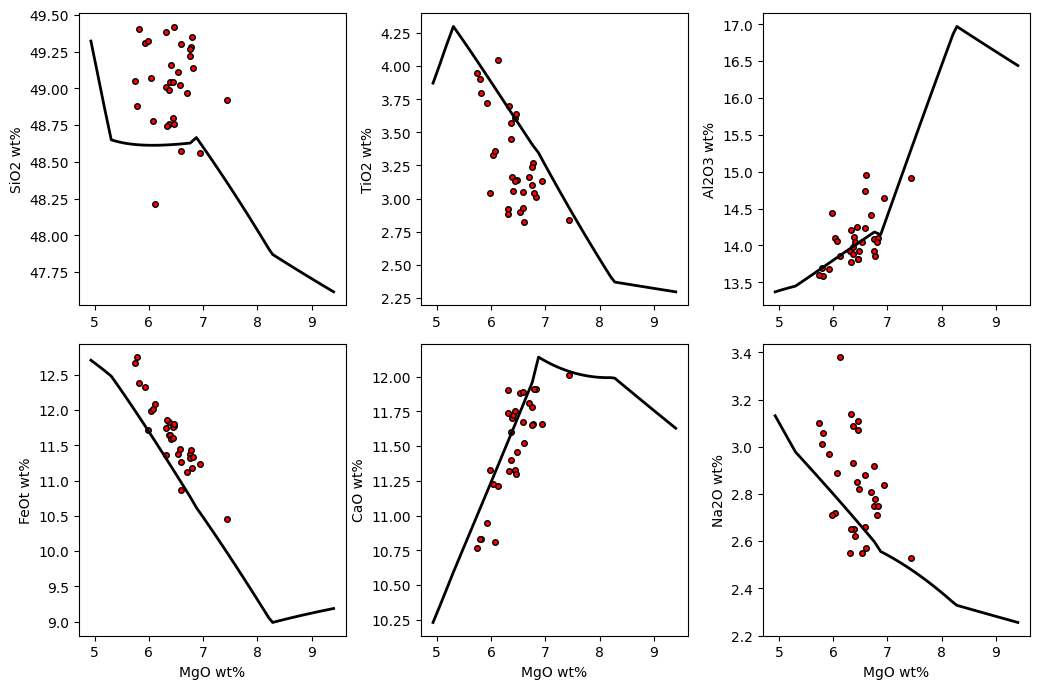

In [37]:
M.harker(Results = Isobaric_Xtal_All['index = 64'], data = MG)